# Applying [JAX](https://github.com/google/jax) to a model with realistic noise, continuum filtering and wavelength sampling.
Brett Morris & Jens Hoeijmakers


This is based on a fork of Brett's retrieval demo, applied to high resolution transmission spectra.

In [92]:
batch = False#Set this to False to enable plotting. Set to True and export the script to perform a batch calcuation.
#In this case, all in-between plotting and speed tests are skipped.

if not batch:
    %matplotlib inline
    import matplotlib.pyplot as plt
    
# We need to import numpyro first, though we use it last
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro import distributions as dist

cpu_cores = 4
numpyro.set_host_device_count(cpu_cores)


import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from jax import numpy as jnp
from jax import jit
from jax.scipy.optimize import minimize
from jax.random import PRNGKey, split
from functools import partial
import arviz
from corner import corner

import astropy.io.fits as fits
import astropy.constants as const
import astropy.units as u 
import h5py

import tayph.util as ut
import tayph.system_parameters as sp
import tayph.functions as fun
import tayph.util as ut
from tayph.vartests import typetest,notnegativetest,nantest,postest,typetest_array,dimtest
from tayph.vartests import lentest
import tayph.operations as ops
import tayph.masking as masking
import copy
from pathlib import Path

from collections import OrderedDict

import jax
rng_seed = 42
rng_keys = split(PRNGKey(rng_seed),cpu_cores)

if batch: 
    print(f'Starting script in batch mode on {cpu_cores} cores.')
    
order_start = 0
order_end = 15




## Loading opacities.
Opacity functions of various species are located in the `opacity/` folder. We load them using a binary IO script packaged in `tayph`. We save each species in a species object, and keep track of those with a dictionary. The first time that this cell is run, the opacities are read from binary files provided. They are converted into fits files and the next time, they will be read from fits files instead; which is much much faster.

In [93]:
class species:#Species
  def __init__(self, label, tag):
    self.label = label
    self.tag = tag
    
reread=False
# labels = ['Ca', 'Ti', 'V', 'Cr', 'Fe']
# tags = [2000,2200,2300,2400,2600]

labels=['Fe','Ti','V','Cr']
tags=[2600,2200,2300,2400]
S = OrderedDict()#This will hold all my species objects.
for i in range(len(labels)):
    S[labels[i]] = species(labels[i],tags[i])
    
    
t1 = ut.start()
for i in list(S.keys()):
    binpath = Path(f'opacity/VALD_{S[i].tag}e2/Out_00000_60000_02500_n800.bin',exists=True)
    fitspath = Path(f'opacity/VALD_{S[i].tag}e2/Out_00000_60000_02500_n800.fits')
    if fitspath.exists()==False or reread == True:
        print(f'Reading opacity {i} from binary.')
        kappa = np.array(ut.read_binary_kitzmann(binpath,double=False))
        ut.writefits(fitspath,kappa)
    
    S[i].path = ut.check_path(fitspath,exists=True)
    S[i].kappa = jnp.array(np.array(fits.getdata(fitspath),dtype='f8'))
t2 = np.round(ut.end(t1,silent=True),1)
print(f'{t2} seconds spent reading opacities.')
      
      
k_wn = jnp.arange(len(S['Fe'].kappa))*1e-2#Wavenumbers
k_wl = 1e7/k_wn#Wavelength in nm; common to all the opacity functions.

0.3 seconds spent reading opacities.


## Loading a dataset
To make a good choice about what to interpolate this onto, we first load in the data. This data is the first transit of KELT-9 b from the Hoeijmakers 2018 paper, observed with HARPS. It's a high-SNR dataset, representative of what you might want to employ high-resolution retrievals on. This code reads spectral orders and wavelengths from file, and generates uncertainties. This is all data prep, and it is copied out of `tayph`, which handles observed spectra in the same way.

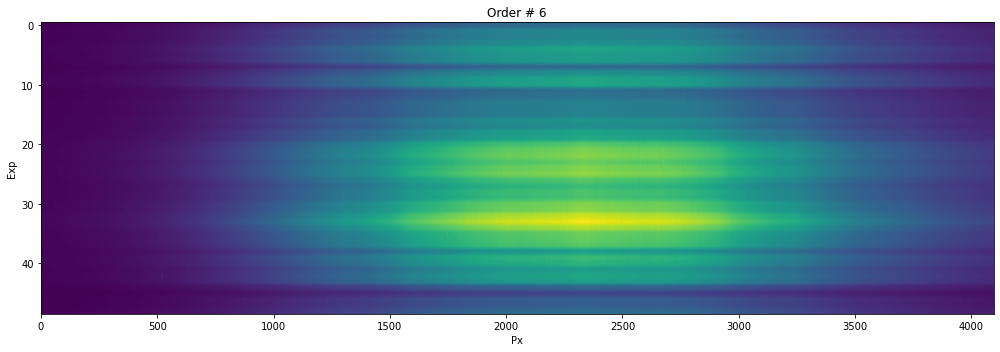

In [94]:
dp = ut.check_path('data/KELT-9/night1/',exists=True)#This follows the file structure of tayph.

list_of_wls=[]#This will store all the data.
list_of_orders=[]
list_of_sigmas=[]

filelist_orders= [str(i) for i in Path(dp).glob('order_*.fits')]
if len(filelist_orders) == 0:#If no order FITS files are found:
    raise Exception(f'Runtime error: No orders_*.fits files were found in {dp}.')
try:
    order_numbers = [int(i.split('order_')[1].split('.')[0]) for i in filelist_orders]
except:
    raise Exception('Runtime error: Failed at casting fits filename numerals to ints. Are the '
    'filenames of all of the spectral orders correctly formatted (e.g. order_5.fits)?')
order_numbers.sort()#This is the ordered list of numerical order IDs.
n_orders = len(order_numbers)


for i in order_numbers:
    wavepath = dp/f'wave_{i}.fits'
    orderpath= dp/f'order_{i}.fits'
    ut.check_path(wavepath,exists=True)
    ut.check_path(orderpath,exists=True)
    wave_order = ut.readfits(wavepath)#2D or 1D?
    order_i = ut.readfits(orderpath)
    list_of_wls.append(ops.airtovac(wave_order))# deal with air wavelengths:

    #Test for negatives, set them to NaN.
    order_i[order_i <= 0] = np.nan #This is very important for later when we are computing
    #average spectra and the like, to avoid divide-by-zero cases.
    list_of_orders.append(order_i)
    list_of_sigmas.append(np.sqrt(order_i))

if not batch:   
    oi = 6 #This is the order that's going to be plotted below.
    plt.figure(figsize=(14,5))
    plt.imshow(list_of_orders[oi],aspect='auto',origin='upper')
    plt.title(f'Order # {oi}')
    plt.xlabel('Px')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()

We now need to do velocity corrections on this data to move to the stellar rest-frame.

In [95]:
rv_cor = sp.berv(dp)-sp.RV_star(dp)

gamma = 1.0+(rv_cor*u.km/u.s/const.c)#Doppler factor.

list_of_orders_cor = []
list_of_sigmas_cor = []
list_of_wls_cor = []

for i in range(len(list_of_wls)):
    order = list_of_orders[i]
    sigma = list_of_sigmas[i]
    order_cor = order*0.0
    sigma_cor = sigma*0.0
    wl_cor = list_of_wls[i]

    for j in range(len(list_of_orders[0])):
        order_cor[j] = interp.interp1d(list_of_wls[i]*gamma[j],order[j],bounds_error=False)(wl_cor)
        sigma_cor[j] = interp.interp1d(list_of_wls[i]*gamma[j],sigma[j],bounds_error=False)(wl_cor)

    list_of_orders_cor.append(order_cor)
    list_of_sigmas_cor.append(sigma_cor)
    list_of_wls_cor.append(wl_cor)

## Using the out-of-transit data for creating a synthetic time series

Now we need to crop out all the in-transit data from these orders, so that we can deal with uncontaminated, out of transit spectra with which to play. We also need to invent a phase axis. And we crop away most redder orders to avoid tellurics, and to make computations faster as we play around.

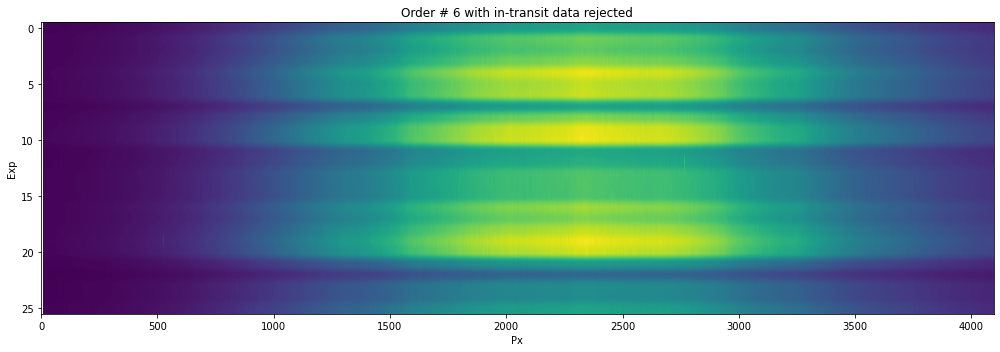

In [96]:
min_wl = np.inf #These are initialised and modified below to determine the extreme wavelengths.
max_wl = 0


mask = sp.transit(dp)
mask[mask<1]=0 #We don't want in-transit spectra 

list_of_orders_oot = []
list_of_wls_oot = []
list_of_sigmas_oot = []
for i in range(order_start,np.min([order_end,len(list_of_orders)])):
    list_of_orders_oot.append(list_of_orders_cor[i][mask==1])
    list_of_wls_oot.append(list_of_wls_cor[i])
    list_of_sigmas_oot.append(list_of_sigmas_cor[i][mask==1])
    min_wl = np.min([np.min(list_of_wls_cor[i]),min_wl])
    max_wl = np.max([np.max(list_of_wls_cor[i]),max_wl])
        
list_of_wld = copy.deepcopy(list_of_wls_oot)
    
if not batch:
    plt.figure(figsize=(14,5))
    plt.imshow(list_of_orders_oot[oi],aspect='auto',origin='upper')
    plt.title(f'Order # {oi} with in-transit data rejected')
    plt.xlabel('Px')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()

n_exp = len(list_of_orders_oot[0])
phase = np.linspace(-0.05,0.05,n_exp)#This will be used later to shift the model.


## Detrending
We will now inspect how the time-residuals in this data behave, and see what we need to normalise, or how to detrend e.g. the continuum.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


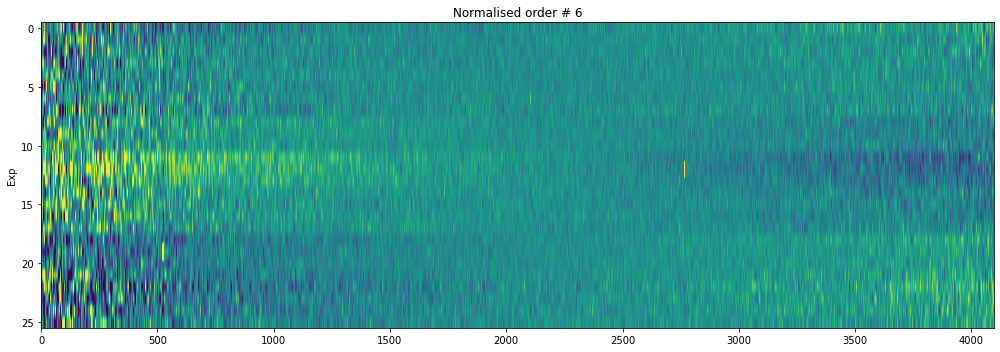

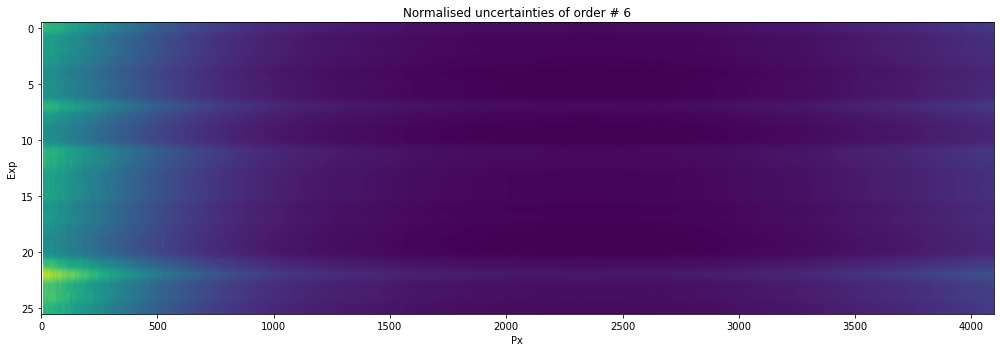

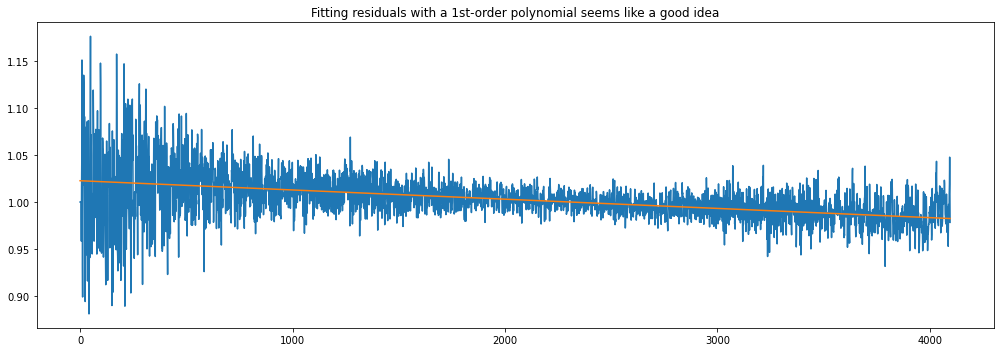

In [97]:

meanfluxes = []#These are the time-dependent average fluxes that we divide out of each order.
meanspecs = []#These are the average spectra that we divide out of each order.
list_of_res = []
list_of_res_e = []

for i in range(len(list_of_orders_oot)):
    order = list_of_orders_oot[i]
    sigma = list_of_sigmas_oot[i]
    meanflux = np.nanmean(order,axis=1)
    meanfluxes.append(meanflux)
    order_norm = (order.T/meanflux).T
    sigma_norm = (sigma.T/meanflux).T
    meanspec = np.nanmean(order_norm,axis=0)
    meanspecs.append(meanspec)
    
    order_clean = order_norm/meanspec
    sigma_clean = sigma_norm/meanspec
    
    #I'm also going to set NaNs to 1.0 and then set sigma to infinite there.
    sigma_clean[np.isfinite(order_clean)==False]=np.inf
    order_clean[np.isfinite(order_clean)==False]=1.0
    
    list_of_res.append(order_clean)
    list_of_res_e.append(sigma_clean)

    

if not batch:
    
    stdev = np.nanmedian(list_of_res_e[oi]) 
    plt.figure(figsize=(14,5))
    plt.imshow(list_of_res[oi],aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev,origin='upper')
    plt.title(f'Normalised order # {oi}')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()   
    
    plt.figure(figsize=(14,5))
    plt.imshow(list_of_res_e[oi],aspect='auto',origin='upper')
    plt.title(f'Normalised uncertainties of order # {oi}')
    plt.xlabel('Px')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()
    
    expfit = 11
    xfit = np.arange(len(list_of_res[oi][expfit]))
    fit = np.polyfit(xfit, list_of_res[oi][expfit], 1,w = 1/list_of_res_e[oi][expfit])
    plt.figure(figsize=(14,5))
    plt.plot(xfit,list_of_res[oi][expfit])
    plt.plot(xfit,np.poly1d(fit)(xfit))   
    plt.title('Fitting residuals with a 1st-order polynomial seems like a good idea')
    plt.tight_layout()
    plt.show()

So this data has a skewed continuum. In the ideal world, a slope in the continuum should be part of the model that I am going to fit. But this will generate at least 2 new free parameters (1st degree polynomial) for each exposure in each order. For 70 orders and 30 exposures, this would be over 4000 new free parameters. I do expect that this could  lead to a system of equations that can be solved in the mcmc because all these free parameters are very much decoupled from the physical parameters of the atmosphere (save the continuum degeneracy that's already there), but lets not tackle that problem for the moment. Instead, we fit these separately and save the filter, supply that to the model and filter the model in the same way. This is equivalent to the strategy of Gibson et al. 2022. This is expected to bias the best-fit model somewhat, but I suspect that for spectral features much smaller than the systematic slopes introduced by the instrument, such biases should be small compared to the line depths themselves, which are already tiny. So let's proceed with the filtering:

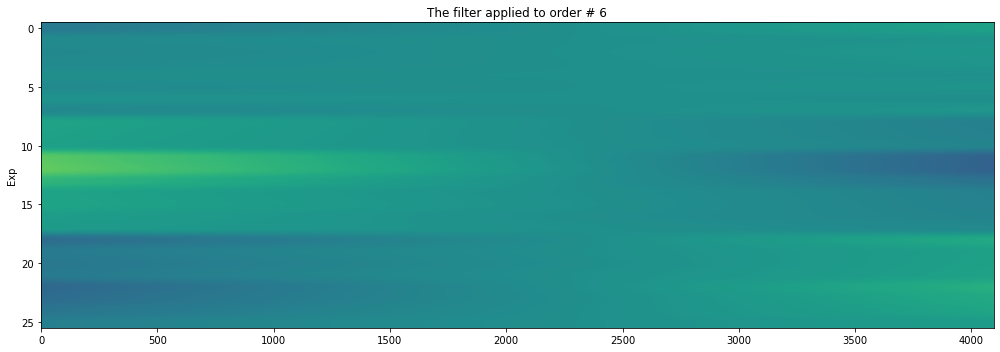

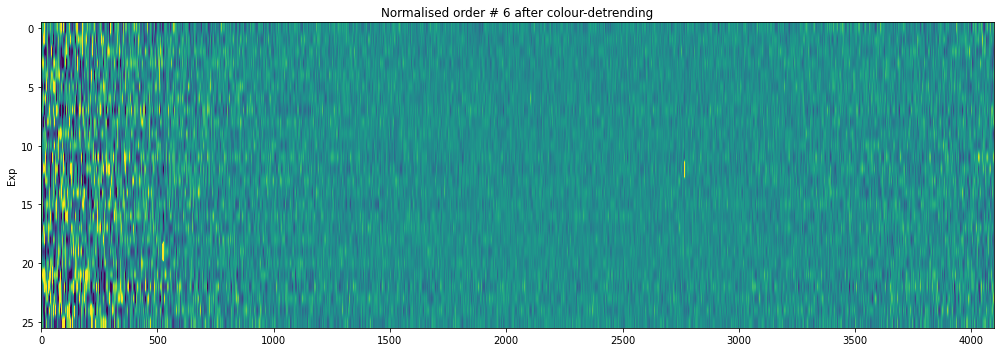

In [98]:
list_of_filters = []
list_of_res_clean = []
list_of_res_clean_e = []
deg = 1
for i in range(len(list_of_res)):
    order = list_of_res[i]
    xfit = np.arange(len(order[0]))
    polyfilter = order*0.0
    fit2d = np.polyfit(xfit,order.T,deg).T

    for j in range(len(order)):
        polyfilter[j] = np.poly1d(fit2d[j])(xfit)
    list_of_filters.append(polyfilter) 
    list_of_res_clean.append(list_of_res[i]/polyfilter)
    list_of_res_clean_e.append(list_of_res_e[i]/polyfilter)

    
if not batch:       
    stdev = np.nanmedian(list_of_res_e[oi])

    plt.figure(figsize=(14,5))
    plt.imshow(list_of_filters[oi],aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev,origin='upper')
    plt.title(f'The filter applied to order # {oi}')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14,5))
    plt.imshow(list_of_res[oi]/list_of_filters[oi],aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev,origin='upper')
    plt.title(f'Normalised order # {oi} after colour-detrending')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()




Buried in this noise is the transmission spectrum, in units of transit radius, which is our primary observable to which we will fit a model. We will now need to make this model applicable to 2D data, and this filter needs to be applied to the model to account for the change in line depth due to the division of that slope. Because the data is now de-trended and the mean is 1.0 per definition, I will now h-stack the data, the uncertainties and the filters. This will make handling the whole dataset a lot easier.<br><br>

Anyway, to apply the filters, I will not divide them out of the data. Instead, I will save these and multiply them against the model. The reason for that is that at some moment, these filters will need to be part of the model.

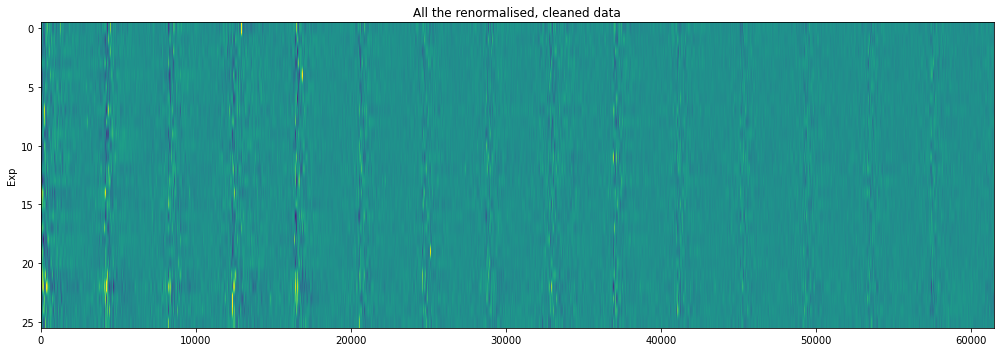

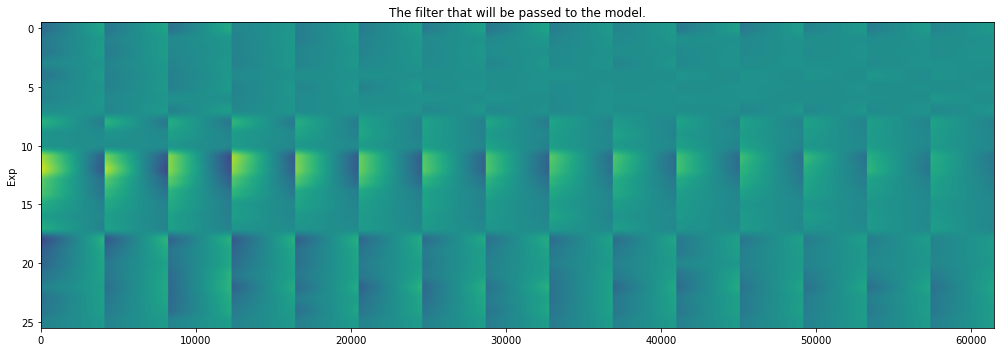

In [99]:
fxd = np.hstack(list_of_res_clean) #This is the data.
err = np.hstack(list_of_res_clean_e)#This is the uncertainty
fxf = np.hstack(list_of_filters)#This is the filter
wld = np.hstack(list_of_wld)#This is the wavelength axis.

if not batch:
    plt.figure(figsize=(14,5))
    plt.imshow(fxd,aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
    plt.title(f'All the renormalised, cleaned data')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14,5))
    plt.imshow(fxf,aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
    plt.title(f'The filter that will be passed to the model.')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()

Interestingly, the filters all have a very correlated shape from order to order. I think that this makes sense, because colour-variation probably depends on the local shape of the SED, which is very similar order to order. Maybe I can leverage this during the retrieval to make that system of equations smaller? Maybe the polynomial coefficient of each exposure in each order can be related to the coefficients of the other orders via a polynomial themselves? If that's a low order polynomial, the number of free parameters would be a few times the number of exposures; rather than the number of orders times the number of exposures... Not sure that this will generalise though... Perhaps a GP?<br><br><br>

Anyway, we now proceed with making the model. The first thing that we're going to do is to prepare the opacities, to convert them to a new wavelength grid that will allow us to blur the resulting transmission spectrum. This again comes straight out of `tayph`.

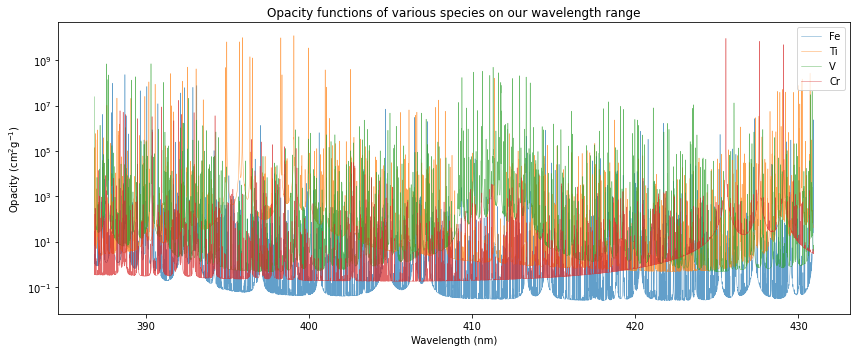

In [100]:
#We are going to bracket the minimum and maximum wavelengths of the intermediate wavelength array by 500 km/s in velocity.
doppler_factor = (500*u.km/u.s / const.c).decompose().value
min_wl*=(1-doppler_factor)
max_wl*=(1+doppler_factor)


for i in list(S.keys()):
    wli,kappa_i,dv = ops.constant_velocity_wl_grid(np.array(k_wl[1:]),np.array(S[i].kappa[1:]),
                                                       oversampling=1.0,minmax=[min_wl,max_wl]) # The intermediate wavelength grid.
                                                        #Index it from 1 onwards because the first value is np.inf.
    S[i].kappa_i = copy.deepcopy(jnp.array(kappa_i))
    
wli = jnp.array(copy.deepcopy(wli))    
    
    
kappa_grid = np.vstack([S[i].kappa_i for i in labels])
n_species = len(kappa_grid)#The first species should be Fe.    
    
    
if not batch:
    plt.figure(figsize=(12,5))

    for i in list(S.keys()):
        plt.plot(wli,S[i].kappa_i,label=i,linewidth=0.5,alpha=0.7)
    plt.yscale('log')
    plt.xlabel('Wavelength (nm)')
    plt.title("Opacity functions of various species on our wavelength range")
    plt.ylabel('Opacity (cm$^2$g$^{-1}$)')
    plt.legend()
    plt.tight_layout()
    plt.show()

So now we have opacity functions interpolated onto a fine-grained constant-dv grid.
The next task is to make a model that matches the order-wise data.  <br><br><br>

## Defining the planet and other physics

In [101]:
gamma = 0.57721
RJ = const.R_jup.cgs.value
MJ = const.M_jup.cgs.value
G = const.G.cgs.value
Rsun = const.R_sun.cgs.value

P0 = (1.0*u.bar).cgs.value#bar
R0 = 1.8*RJ
M0 = 1.2*MJ
k = const.k_B.cgs.value
m = 2.33*const.u.cgs.value
Rs = 1.4*Rsun
g = G*M0 / R0**2

c = const.c.to('km/s').value
Kp = 200.0#Some test variables.
vsys = 20.0





## The model function

Let's specify the model that we will fit to the data using the numpy module within jax. We'll also "decorate" it with the `jit` decorator, which will compile the function for us at runtime. 

This model is complicated for three reasons.<br>
First of all, because there is a variety of species. Each of these has their own opacity function and abundance. I set it up such that the first species provided is Fe, and all the other species are then measured relative to Fe.<br>
Secondly, the model needs to be broadened and shifted. This adds more free parameters, and a convolution operation.<br>
Thirdly, the data is 2D, meaning that the number of datapoints is massive.<br><br><br><br>
The smart way to solve the first issue, is to keep the chosen opacities general. So unlike the previous notebook where the species were hardcoded, we now choose to pass the opacity functions as a matrix, ordered such that the first row is the Fe opacity, and the remaining rows are opacity functions that correspond to the order of the abundances relative to Fe, as supplied in the parameter `p` which encodes the free parameters.

We define the model in two flavours. The first is the numpy model, which is expected to be slow. The second is the just-in-time compiled model, and we'll compare the performance of the two.

In [102]:
def model_numpy(p,wl,kappa_grid):
    #First we unpack our free parameters:
    n_species = len(kappa_grid)
    T = p[0]
    chi_fe = 10**p[1]
    logratios = jnp.array(p[2:n_species+1]) #Add a zero for Fe itself. Is this going to mess up autodif?
    logk0 = p[n_species+1]
    c0 = p[n_species+2] #Constant offset to ensure continuum-degeneracy despite filtering. 
    
    #Then we compute kappa:
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    
    #Then we do the magic:
    H = k*T/m/g
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    return (c0-R**2 / Rs**2)


@jit
def model_jax(p,wl,kappa_grid):
    #This model is the exact same as above, just with the jit decorator.
    n_species = len(kappa_grid)
    T = p[0]
    chi_fe = 10**p[1]
    logratios = jnp.array(p[2:n_species+1])
    logk0 = p[n_species+1]
    c0 = p[n_species+2]
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    H = k*T/m/g
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    return (c0-R**2 / Rs**2)

In [103]:
if not batch:
    #The timed comparison:
    N=300
    p = [2500.0,-5.0,-1.0,-2.0,-1.5,-2.0,1.0]# The model parameters: T, Fe, 2 other species relative to Fe, log(k0), c0.
    t1=ut.start()
    for i in range(N):
        model_numpy(p,wld,kappa_grid)
    t2 = ut.end(t1,silent=True)/N
    print(f'Elapsed time per numpy model: {np.round(t2*1000,3)} ms')


    t1=ut.start()
    for i in range(N):
        model_jax(p,wld,kappa_grid)
    t2 = ut.end(t1,silent=True)/N
    print(f'Elapsed time per jax model: {np.round(t2*1000,3)} ms')

Elapsed time per numpy model: 5.705 ms
Elapsed time per jax model: 1.367 ms


If all went well, the jax model is significantly faster (about 3 to 4 times) than numpy. That's great!
<br><br><br>

## Traced versus static variables

This is drop-in type addition of just-in-time compilation and JAX's version of numpy are only the beginning to effectively code with JAX. In JAX, there is a difference between static and traced variables. Traced variables can be seen as the free parameters of a function. Static variables are the constants. <br><br>
For example, the function f(x)=a*x + b is commonly understood to have one free parameter and two coefficeints. We could code that up as `def f(x,a,b):...`. However to python and JAX, x, a and b would all be equally free parameters.<br><br>
Instead, if a parameter is really <b>not</b> free (for example because they are natural constants that are always the same, no matter in what situation the function is called), they could be hard-coded when the function is compiled. These are <i>static</i> variables in JAX, and it turns out that reducing the number of free function parameters has the potential to make our compiled code faster (see relevant docs [here](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html)). Variables that define the shape of other various even <b>have</b> to be static variables, because JAX can't compile your function if it doesn't know the shape of the variables in advance.<br><br><br>
For our problem, using static variables to try to increase the computation speed may be significant because you can consider the opacity functions of atoms to be natural constants. In fact, the model that we're fitting to the data has a small number of physical free parameters (temperature, abundances), but many things are fixed, meaning that they don't change while the MCMC sampler is traversing likelihood space. That includes the opacities, but also the wavelength grid of the data (which is needed to interpolate onto), some system parameters (g, P0, R0), and the de-trending filter.<br><br><br>
Unfortunately, one issue with static variables is that they are not allowed to be numpy arrays or lists. I worked out a way to convert these big 2D matrices to flat byte arrays, which are hashable, and then, passing the dimensions of these arrays as additional function parameters. Inside the function, these byte arrays would then be converted back to numpy arrays, and used in the remainder of the calculation. However, I found out that in the present model, the handling of e.g. the opacity functions is not going to be the slowest operation in this model, so I left that for another day. We will be using some static variables though, but those will be the single constants, and we'll do that later on.<br><br><br>

Because first, we still have a lot of other work to do. Importantly, the spectrum needs to be convolved (broadened) to take into account the non-zero-width line-spread function, and it needs to be interpolated onto the data's wavelength array. Let's solve those two problems next.
<br><br>

## Convolution
A very interesting question is <b>what</b> should actually be convolved. The spectrum? The transit radius? Or even the opacity function? In theory, it depends on when various effects are happening. Velocity broadening due to the motion of particles in the atmosphere (or the atmosphere as a whole), may need to be modelled as a convolution of the opacity function itself. However, the effect of the line-spread function of the spectrograph is something that happens to the spectrum that enters the telescope. A model that simply broadens the transit radius or the transmission spectrum is a simplification, and I wonder how other authors deal with that. E.g. Julia Seidel's vertical-wind paper probably shifts the opacity function of each cell when doing the radiative transfer. Of course, the analytical formula is not suitable for this. So for now, we'll keep this as simple as possible.<br><br>
We will approach it by first defining the velocity range over which the Gaussian blur kernel needs to be defined. We call this `x_kernel`. This will be defined as a grid of radial velocities, and for each line-width (in km/s), the kernel will have a constant size regardless of wavelength, because the opacity functions are defined on a constant-velocity-step grid. So if we make the sampling of `x_kernel` match that of the grid of $\kappa$, we can use the standard convolution function of numpy. All we need to do is define `x_kernel` to be wide enough, such that it will be able to contain blur kernels with various widths during the fit.

In [104]:
def model_conv_numpy(p,wl,kappa_grid,x_kernel):
    #First we unpack our free parameters:
    n_species = len(kappa_grid)
    T = p[0]
    chi_fe = 10**p[1]
    logratios = jnp.array(p[2:n_species+1]) #Add a zero for Fe itself. Is this going to mess up autodif?
    logk0 = p[n_species+1]
    c0 = p[n_species+2] #Constant offset to ensure continuum-degeneracy despite filtering. 
    lw = p[n_species+3]
    
    #Then we compute kappa:
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    
    #Then we do the magic:
    H = k*T/m/g
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    
    RT = c0-R**2 / Rs**2
    
    kernel = jnp.exp(-0.5 * x_kernel**2 / lw**2) #/ ( lw*jnp.sqrt(2*np.pi) )
#     plt.plot(x_kernel,kernel)
#     plt.show() #Looking good.
    RT_b = jnp.convolve(RT,kernel/jnp.sum(kernel),mode='same')
    return (RT_b)

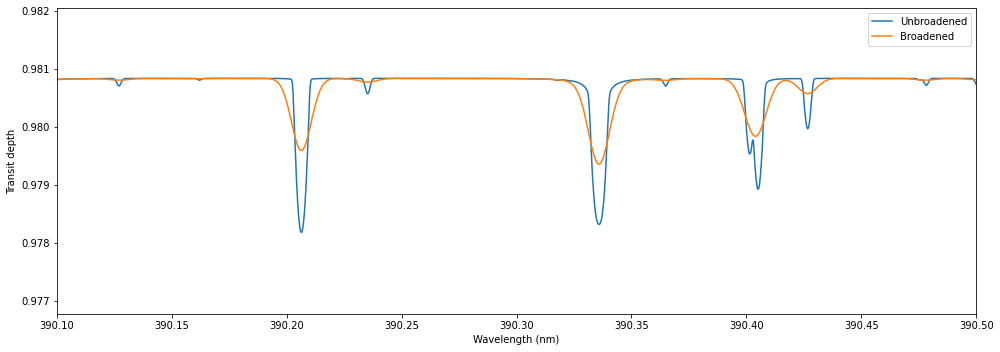

Elapsed time per numpy model: 170.629 ms


In [106]:
nwli = len(wli)
nwld = len(wld)
nexp = len(fxf)

sfwhm = 2*jnp.sqrt(2*np.log(2))#2.355...


#We calculate what range we want for the convolution kernel.
mf=5.0#max_fwhm_expected
nf=4.0#How many times wider the kernel is compared to the fwhm of the lsf?
k_size = int(mf/dv*nf)
if k_size%2 == 0: k_size+=1#Make sure that it is odd.
x_kernel = (jnp.arange(k_size)-(k_size-1)/2)*dv #This places 0 directly in the middle; and serves as the x axis of our convolution. On-the-fly, this will be used to calculate a gaussian with which to convolve.



if not batch:
    fx = model_numpy(p,wld,kappa_grid)
    p2 = [2500.0,-5.0,-1.0,-2.0,-1.5,-2.0,1.0,3.0]
    fx_b = model_conv_numpy(p2,wld,kappa_grid,x_kernel)
    yrange = np.max(fx)-np.min(fx)
    plt.figure(figsize=(14,5))
    plt.plot(wli,fx,label='Unbroadened')
    plt.plot(wli,fx_b,label='Broadened')
    plt.legend()
    plt.xlim(390.1,390.5)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Transit depth')
    plt.ylim(np.max(fx)-yrange,np.max(fx)+0.3*yrange)
    plt.tight_layout()
    plt.show()

    N=20#We need to decrease the number here, because convolution is slow.
    t1=ut.start()
    for i in range(N):
        model_conv_numpy(p2,wld,kappa_grid,x_kernel)
    t2 = ut.end(t1,silent=True)/N
    print(f'Elapsed time per numpy model: {np.round(t2*1000,3)} ms')

So this convolution has made things some 20x slower, meaning that 95% of the time is spent not calculating a transmission spectrum. In principle this not great news, but it does mean that we don't need to be very worried about the (lack of) accuracy of our analytical model, nor by the 2D-ness of our model later on (which would not increase the time spent in convolution). More complex models may still be bottlenecked by this convolution. <br><br> Next, lets see how long JAX takes here. 

In [107]:
@jit
def model_conv_jax(p,wl,kappa_grid,x_kernel):

    T = p[0]
    chi_fe = 10**p[1]
    logratios = jnp.array(p[2:n_species+1]) #Add a zero for Fe itself. Is this going to mess up autodif?
    logk0 = p[n_species+1]
    c0 = p[n_species+2] #Constant offset to ensure continuum-degeneracy despite filtering. 
    lw = p[n_species+3]
    
    #Then we compute kappa:
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    
    #Then we do the magic:
    H = k*T/m/g
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    
    RT = c0 - R**2 / Rs**2
    
    kernel = jnp.exp(-0.5 * x_kernel**2 / lw**2) #/ ( lw*jnp.sqrt(2*np.pi) )
#     plt.plot(x_kernel,kernel)
#     plt.show() #Looking good.
    RT_b = jnp.convolve(RT,kernel/jnp.sum(kernel),mode='same')
    #I explicitly divide by the sum of the kernel instead of doing the analytical normalisation above, 
    #to deal with cases that the kernel is so wide that it starts going over the edge, reducing the integrated
    #area.
    
    return (RT_b)

In [108]:


if not batch:
    t1=ut.start()
    N=50
    for i in range(N):
        model_conv_jax(p2,wld,kappa_grid,x_kernel)
    t2 = ut.end(t1,silent=True)/N
    print(f'Elapsed time per model: {np.round(t2*1000,3)} ms')


Elapsed time per model: 70.835 ms


This seems to be a factor of about 2x faster than numpy, and it looks like the convolution still dominates our calculation time.
It may be possible to express this convolution as a matrix operation in a smart way later, but for now we'll stick with this. ~50ms for a velocity-broadened model is still very good, because running thousands of models will still be very tractable.<br><br><br>

## Expanding the model to two dimensions
The next step is to interpolate this model onto the wavelength and phase grid of the data. That goes in two dimensions, and requires the keplerian of the orbit, derived from the orbital phase. We first show how this works outside of the jax function, and then implement it.<br><br>
Note that the data wavelength array contains breaks and overlaps. This is not a concern for the interpolation, though, because although `jnp.interp()` requires the 1D spectrum to have monotonically increasing values, the interpolates can be freely chosen. Also note that we do not care about edge effects here. We had chosen the model to be wider than the data, so the interpolated 2D time-series will not have crossed the boundaries of the model.<br><br>
In this model we should still divide out the mean of the model, which we have done in the data, but we'll leave that for now. Not doing that should be corrected for by using c0, a constant offset. <br><br>

Let's first see step-wise how we are going to do this. First, we take our phase range and multiply it by a large number so that we can visualise more clearly how the planet's spectrum moves along the orbit. We compute the instantaneous radial velocity using the phase, the orbital velocity $K_p$ and a constant offset $v_{sys}$. Then we compute a 1D-model and interpolate it onto an array of doppler-shifted data wavelengths. This is done using an outer product between the doppler shift (as a function of time) and the wavelength axis, creating a 2D grid of wavelengths onto which the model can be interpolated. This takes down three birds with one stroke. First of all, it creates the 2D time series. Second, it doppler shifts the 1D spectrum. Third, it interpolates onto the wavelength grid of the data.

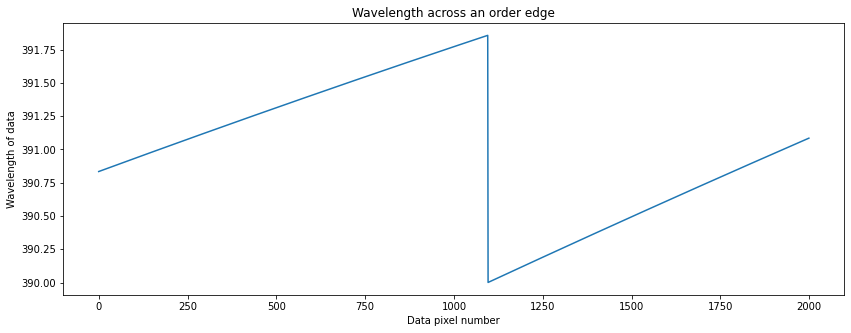

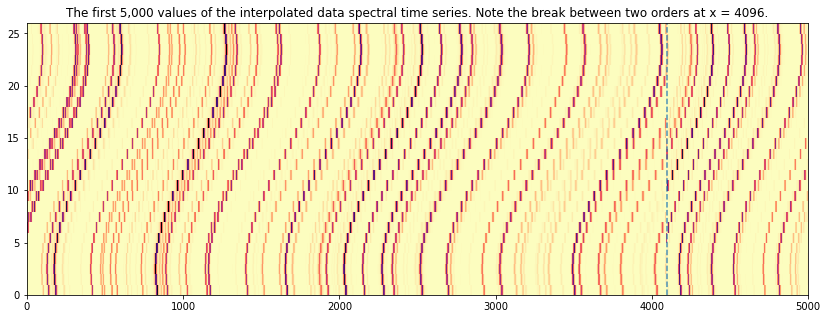

In [109]:
if not batch:
    phase_test = phase*6#We artificially increase the phase here to make the sinusoid of the orbit visible.

    rvp = jnp.sin(phase_test*2*np.pi)*Kp + vsys#The equation of a circle.
    df = 1-rvp/c#The doppler factor associated with these velocities. There is a minus sign here because of the direction of the interpolation.

    shifted_wld = jnp.outer(df,wld)#This is a big 2D matrix with shape n_phase x n_wld. So that is as large as the data.

    spec = model_conv_jax(p2,wld,kappa_grid,x_kernel)
    spec2D = np.interp(shifted_wld,wli,spec)


    plt.figure(figsize=(14,5))
    plt.plot(wld[3000:5000])
    plt.xlabel('Data pixel number')
    plt.ylabel('Wavelength of data')
    plt.title('Wavelength across an order edge')
    plt.show()
    plt.figure(figsize=(14,5))
    plt.pcolormesh(spec2D[:,0:5000],shading='auto',cmap='magma')
    plt.title('The first 5,000 values of the interpolated data spectral time series. Note the break between two orders at x = 4096.')
    plt.axvline(4096,linestyle='--',alpha=0.8)
    plt.show()

So that is looking great! Even the order-break is interpolated nicely. Implementing this into the JAX function is now very easy. Note that we also choose to change the input of the log-ratios of the elemental abundances, to be a single jnp.array(). Then, in order to start running MCMCs, we will simulate data and perform fits.<br><br>

The numpyro model below defines the priors. Additionally, you can add a free parameter that describes a scaling of the noise. This $\beta$ parameter can be turned on or off by commenting/uncommenting the line that defines it's prior, and multipying the errors in `numpyro.sample()` as `scale = y_e*beta`. This gives the model more freedom handle errors in your estimate of the uncertainties, but it makes exploration of parameter space much less efficient.

In [110]:
@partial(jit, static_argnums=(6,7,8,9,10,11,12,13,14))
def model_jax(p,wl,wlk,kappa_grid,x_kernel,phase,c,gamma,k,m,g,P0,R0,Rs2,n_species):
#     T,chi_fe,logratios,logk0,c0,lw,vsys,Kp,wl,wlk,kappa_grid,x_kernel,phase,c,gamma,k,m,g,P0,R0,Rs2,n_species = p

    T = p[0]
    chi_fe = 10**p[1]
    logratios = p[2] #This is now a jnp.array().
    logk0 = p[3]
    c0 = p[4] #Constant offset to ensure continuum-degeneracy despite filtering. 
    lw = p[5]
    vsys = p[6]
    Kp = p[7]

    #Then we compute kappa:
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    
    #Then we do the magic:
    H = k*T/m/g
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    RT = c0-R**2 / Rs**2
    
    #Then we convolve:
    kernel = jnp.exp(-0.5 * x_kernel**2 / lw**2)
    RT_b = jnp.convolve(RT,kernel/jnp.sum(kernel),mode='same')
    
    #Then we populate the 2D time series:
    rvp = jnp.sin(phase*2*np.pi)*Kp + vsys #Radial velocity of the planet as a function of the orbital phase.
    
    shifted_wl = jnp.outer(1-rvp/c,wl)#This populates a 2D matrix containing a row of shifted wavelengths for each of the spectra.
    spec2D = jnp.interp(shifted_wl,wlk,RT_b) # * filters
    
    return(spec2D)









def numpyro_model(y,y_e,*args):
    
    T_prior = numpyro.sample('T', dist.Uniform(low=1500, high=3500))
    
    chi_fe_prior = numpyro.sample(
       'log($\chi_{Fe}$)', dist.Uniform(low=-5.0, high=-3.0))

    chi_species_priors = numpyro.sample('log($\chi$ / $\chi_{Fe}$)', dist.Uniform(low=-3.5, high=-0.5),sample_shape=(n_species-1,))

    k0_prior = numpyro.sample('log($\kappa_0$)', dist.Uniform(low=-4.0, high=-1.0))

    c_prior = numpyro.sample('c0', dist.Uniform(low=0.998, high=1.002))
    
    lw_prior = numpyro.sample('lw', dist.Uniform(low=2, high=8))
    vsys_prior = numpyro.sample('$v_{sys}$', dist.Uniform(low=16, high=24))
    Kp_prior = numpyro.sample('$K_p$', dist.Uniform(low=130, high=170))
    
    # beta = numpyro.sample('$\\beta$', dist.Uniform(low=0.5, high=2.0))
    
    priors = [T_prior,chi_fe_prior,chi_species_priors,k0_prior,c_prior,lw_prior,vsys_prior,Kp_prior]
    
    # Normally distributed likelihood
    numpyro.sample("obs", dist.Normal(loc=model_jax(priors,*args),scale=y_e), obs=y)



## Defining the data

The success of the sampler depends on the amount of data as well as the noise. 
Above, we have limited the wavelength range of the data to span only a number of orders. 
The data also came with a fake phase range for the 26 exposures of our dataset. 
Now below, we define a much smaller phase-range to only sub-sample a small part of our data for now. 
And we assume various flavours of the noise.
<br>
First, the 'data' is simply the model plus pure normally distributed noise, with equal standard deviation at all wavelengths.
<br>
Second, that noise term is made dependent on wavelength, using the standard deviation measured from the data, before.
<br>
Finally, we inject the model into the data via multiplication with the real data, which gives us real noise, including whatever
systematic effects there may be in the data.

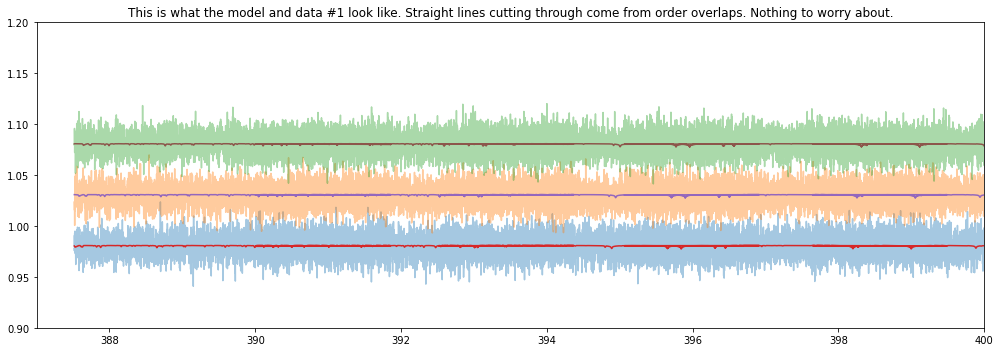

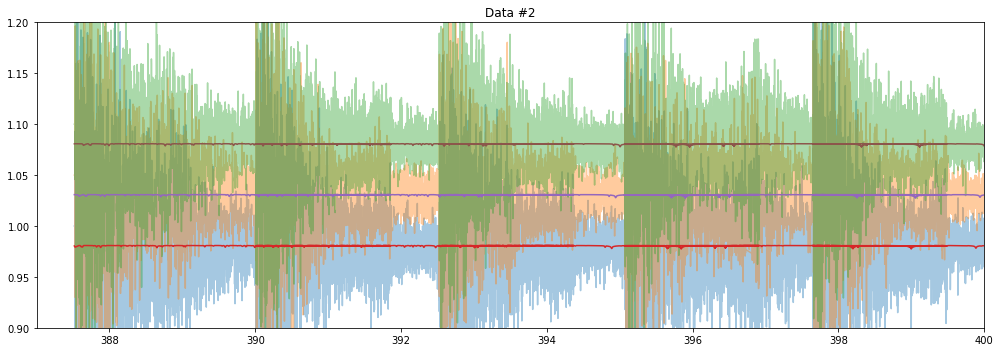

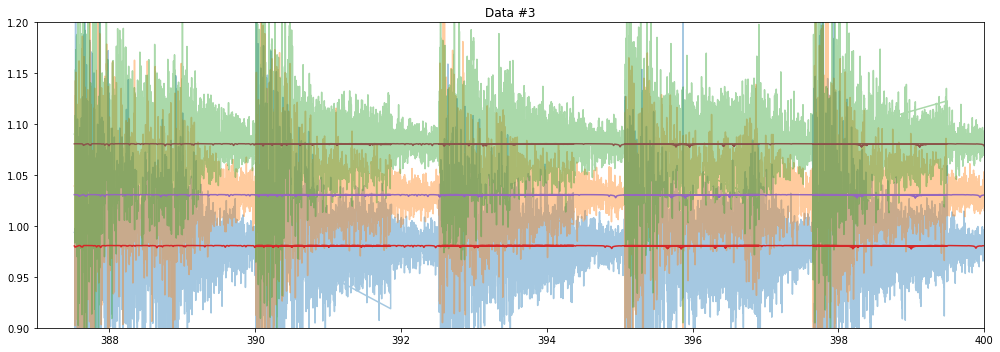

Elapsed time per JAX model: 0.41 ms


In [111]:
#The next step would be to inject the model into the data before cleaning takes place.
true_p = [2500.0,-4.0,jnp.array([-1.0,-2.0,-1.5]),-2.0,1.0,4.0,20.0,150.0]

phase = jnp.array([-0.1,-0.05,0,0.05,0.1])
true_model = model_jax(true_p,wld,wli,kappa_grid,x_kernel,jnp.array(phase),c,gamma,k,m,g,P0,R0,Rs**2,n_species)

#A model with uniform pure gaussian noise.
NOISE_1 = 0.01
DATA_1 = true_model + np.random.normal(loc=0.0,scale=NOISE_1,size=(len(phase),len(wld)))
DATA_1_E = DATA_1*0.0+NOISE_1

#A model with pure gaussian noise equal to that measured in the data.
#Jax doesn't like infinite values (NaNs, np.inf). I need to replace these:
DATA_2 = true_model + np.random.normal(loc=0.0,scale=1.0,size=(len(phase),len(wld))) * err[0:len(phase)]
DATA_2 = np.array(DATA_2)
DATA_2[~np.isfinite(DATA_2)] = 1.0
DATA_2_E = np.array(err[0:len(phase)])
DATA_2_E[~np.isfinite(DATA_2_E)] = 5.0 # A large error.
DATA_2_E = jnp.array(DATA_2_E)




#A model injected into real data.
DATA_3 = np.array(fxd[0:len(phase)] * true_model)
DATA_3[~np.isfinite(DATA_3)] = 1.0
DATA_3 = jnp.array(DATA_3)

DATA_3_E = copy.deepcopy(DATA_2_E)


if not batch:
    XLIM = [387,400]
    YLIM = [0.9,1.2]
    
    plt.figure(figsize=(14,5))
    plt.plot(wld,DATA_1[0],alpha=0.4)
    plt.plot(wld,DATA_1[1]+0.05,alpha=0.4)
    plt.plot(wld,DATA_1[2]+0.1,alpha=0.4)
    plt.plot(wld,true_model[0])
    plt.plot(wld,true_model[1]+0.05)
    plt.plot(wld,true_model[2]+0.1)
    plt.ylim(YLIM[0],YLIM[1])
    plt.title('This is what the model and data #1 look like. Straight lines cutting through come from order overlaps. Nothing to worry about.')
    plt.xlim(XLIM[0],XLIM[1])
    plt.tight_layout()
    plt.show()    
    
    plt.figure(figsize=(14,5))
    plt.plot(wld,DATA_2[0],alpha=0.4)
    plt.plot(wld,DATA_2[1]+0.05,alpha=0.4)
    plt.plot(wld,DATA_2[2]+0.1,alpha=0.4)
    plt.plot(wld,true_model[0])
    plt.plot(wld,true_model[1]+0.05)
    plt.plot(wld,true_model[2]+0.1)
    plt.ylim(YLIM[0],YLIM[1])
    plt.title('Data #2')
    plt.xlim(XLIM[0],XLIM[1])
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14,5))
    plt.plot(wld,DATA_3[0],alpha=0.4)
    plt.plot(wld,DATA_3[1]+0.05,alpha=0.4)
    plt.plot(wld,DATA_3[2]+0.1,alpha=0.4)
    plt.plot(wld,true_model[0])
    plt.plot(wld,true_model[1]+0.05)
    plt.plot(wld,true_model[2]+0.1)
    plt.ylim(YLIM[0],YLIM[1])
    plt.title('Data #3')
    plt.xlim(XLIM[0],XLIM[1])
    plt.tight_layout()
    plt.show()    


    N=5
    t1=ut.start()
    for i in range(N):
        true_model = model_jax(true_p,wld,wli,kappa_grid,x_kernel,phase,c,gamma,k,m,g,P0,R0,Rs**2,n_species)
    t2 = ut.end(t1,silent=True)/N
    print(f'Elapsed time per JAX model: {np.round(t2*1000,3)} ms')




## Running the MCMC

The below sets up the MCMC run, and runs it on one of the versions of the data. DATA_1 with 20 warmup steps and 40 samples runs for about 103 minutes on my laptop. The number of warmup steps are important because they are used by the algorithm to learn how to step through likelihood space. The remaining samples are then used to build up the posterior. <br><br>

This cell outputs a statistic of the result, with the retrieved parameters, their uncertainties and also the number of effective samples per parameter (this should ideally be a statistical sample, i.e. hundreds to thousands), as well as a convergence statistic.

In [112]:

# Define a sampler, using here the No U-Turn Sampler (NUTS)
# with a dense mass matrix:
sampler = NUTS(
    numpyro_model, 
    dense_mass=True,    
    #target_accept_prob = 0.95#,  
    max_tree_depth=7
)

# Monte Carlo sampling for a number of steps and parallel chains: 
mcmc = MCMC(
    sampler, 
    num_warmup=20, 
    num_samples=50, 
    num_chains=cpu_cores,
    chain_method = 'parallel'
)

# Run the MCMC
t1 = ut.start()
mcmc.run(rng_keys,DATA_3,DATA_3_E,wld,wli,kappa_grid, x_kernel,phase,c,gamma,k,m,g,P0,R0, Rs**2,n_species)
mcmc.print_summary()
duration = ut.end(t1)
print(f'{np.round(duration/60.0,1)} minutes spent in MCMC.')
import pickle as pickle
with open('MCMC-result.pkl','wb') as f:
        pickle.dump(mcmc, f, pickle.HIGHEST_PROTOCOL)



  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

W0624 20:42:54.435708 140734765135296 host_callback.py:493] jax_host_callback_outfeed is False, but the CustomCall features for host_callback are not available in this version of jaxlib.
W0624 20:42:54.441740 140734765135296 host_callback.py:493] jax_host_callback_outfeed is False, but the CustomCall features for host_callback are not available in this version of jaxlib.
W0624 20:42:54.445669 140734765135296 host_callback.py:493] jax_host_callback_outfeed is False, but the CustomCall features for host_callback are not available in this version of jaxlib.



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                       $K_p$    150.49      1.50    150.48    147.99    152.89    171.17      1.00
                   $v_{sys}$     19.82      0.72     19.84     18.84     21.05     67.26      1.06
                           T   2980.88    323.45   3005.49   2540.30   3494.14    113.46      1.00
                          c0      1.00      0.00      1.00      1.00      1.00     43.34      1.07
log($\chi$ / $\chi_{Fe}$)[0]     -1.06      0.33     -1.04     -1.50     -0.51     34.12      1.11
log($\chi$ / $\chi_{Fe}$)[1]     -2.14      0.42     -2.18     -2.77     -1.46     67.89      1.04
log($\chi$ / $\chi_{Fe}$)[2]     -1.42      0.55     -1.33     -2.17     -0.54     61.85      1.04
            log($\chi_{Fe}$)     -4.01      0.50     -4.03     -4.91     -3.36     28.79      1.14
             log($\kappa_0$)     -1.63      0.45     -1.56     -2.28     -1.00     32.11      1.11
         

## Corner plot

If you didn't select too large a number of samples, the below cell can be used to create a corner plot. With 40 samples, the outlines of the posterior distributions should already be well visible.


                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                       $K_p$    150.49      1.50    150.48    147.99    152.89    171.17      1.00
                   $v_{sys}$     19.82      0.72     19.84     18.84     21.05     67.26      1.06
                           T   2980.88    323.45   3005.49   2540.30   3494.14    113.46      1.00
                          c0      1.00      0.00      1.00      1.00      1.00     43.34      1.07
log($\chi$ / $\chi_{Fe}$)[0]     -1.06      0.33     -1.04     -1.50     -0.51     34.12      1.11
log($\chi$ / $\chi_{Fe}$)[1]     -2.14      0.42     -2.18     -2.77     -1.46     67.89      1.04
log($\chi$ / $\chi_{Fe}$)[2]     -1.42      0.55     -1.33     -2.17     -0.54     61.85      1.04
            log($\chi_{Fe}$)     -4.01      0.50     -4.03     -4.91     -3.36     28.79      1.14
             log($\kappa_0$)     -1.63      0.45     -1.56     -2.28     -1.00     32.11      1.11
         

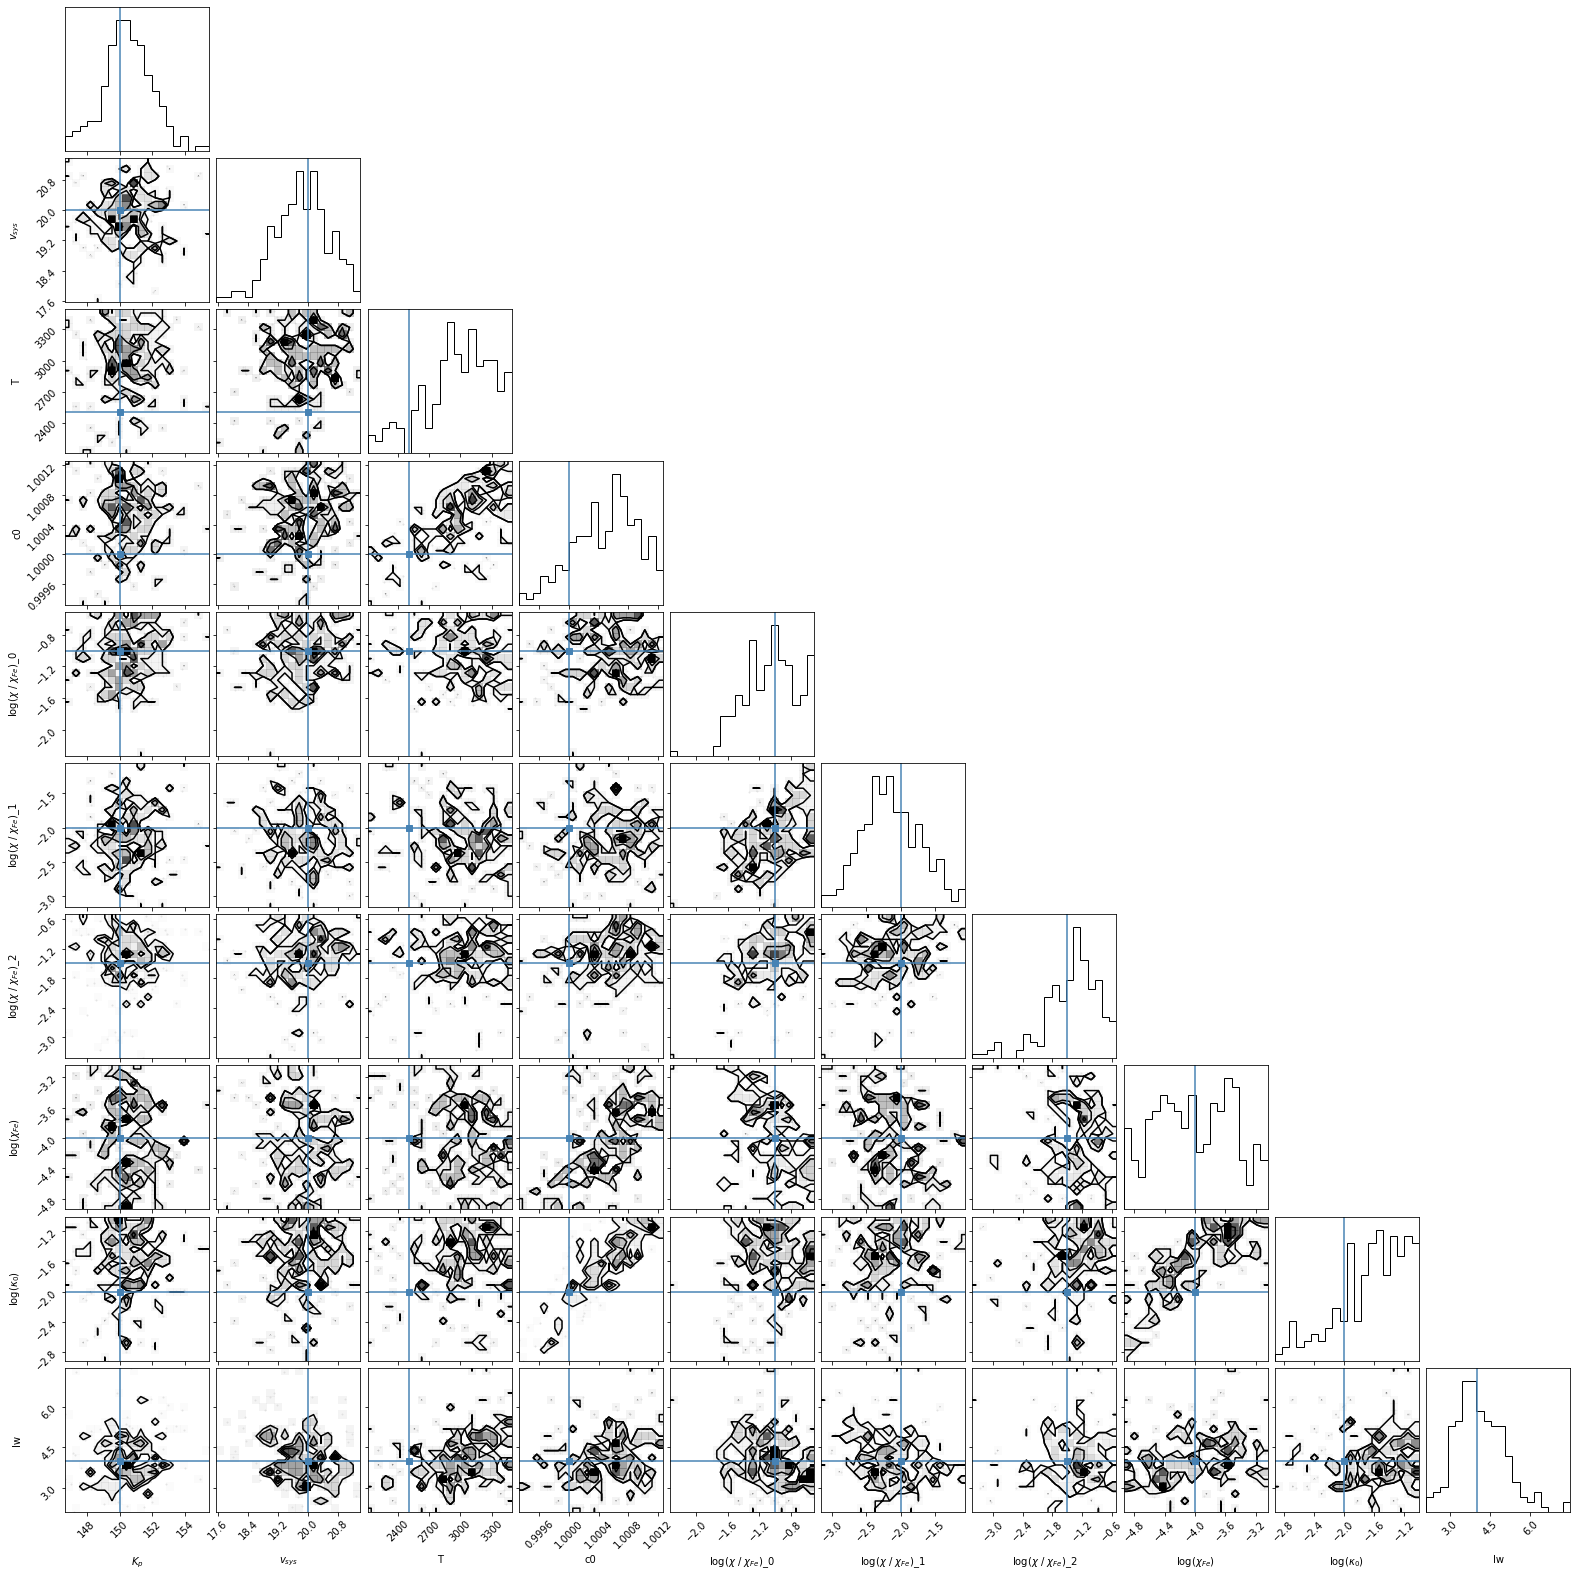

In [115]:
#Run the first cell if you haven't already done so.
if not batch:
    import pickle5 as pickle
    with open('MCMC-result.pkl', 'rb') as inp:
        mcmc = pickle.load(inp)

#     result = arviz.from_numpyro(mcmc)
#     corner(result, quiet=True,truths=truths); 

    mcmc.print_summary()
    truth_dict = {'T': true_p[0],
               'log($\chi_{Fe}$)': true_p[1], 
              'log($\chi$ / $\chi_{Fe}$)_0' : true_p[2][0],
              'log($\chi$ / $\chi_{Fe}$)_1' : true_p[2][1],
              'log($\chi$ / $\chi_{Fe}$)_2' : true_p[2][2],
              'log($\kappa_0$)': true_p[3], 
              'c0': true_p[4],
              'lw': true_p[5],
              '$v_{sys}$': true_p[6],
              '$K_p$': true_p[7],
              '$\\beta$' : 1.0
             }
    



    sample_dict = mcmc.get_samples().items()
    samples = []
    labels = []
    truths = []
    
    for k,v in sample_dict:
        if np.ndim(v) == 1:
            samples.append(v)
            labels.append(k)
            truths.append(truth_dict[k])
        else:
            for i in range(len(v.T)):
                samples.append(v.T[i])
                labels.append(k+f'_{i}')
                truths.append(np.float(truth_dict[k+f'_{i}']))
        
    
    corner(
        np.vstack(samples).T, 
        quiet=True, 
        truths=truths,
        labels = labels
    );
    plt.savefig('Posterior.png')

## Lessons learned
<br>

- The above implementation works for all three versions of the data. Including the injection.
- The bottleneck is very likely the convolution, even for large numbers of exposures. We should investigate if a fast way exists to compute this, apart from jnp.convolve().
- The above implementation works for all three data types.
- Inclusion of the $\beta$ parameter significantly slows down the computation, and it also makes the sampling of all parameters that are not $\beta$ very inefficient. Keeping a tight prior on $\beta$ might help.
- The `max_tree_depth` parameter greatly speeds up sampling. From over 1 hour to 15 minutes for 20+40 samples with `max_tree_depth=7`. 40+160 takes less than an hour. 40+480 takes 2.5 hours.<br><br><br>


The final step in this story is to make this work for real, unfiltered data. The model has to be injected into the data at an earlier stage. This will be the topic of the final notebook.